In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle 

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 706 kB 7.4 MB/s 
     |████████████████████████████████| 5.9 MB 66.0 MB/s 
     |████████████████████████████████| 419 kB 74.7 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [ ]:
import pytorch_lightning as pl
import pandas as pd
import cv2
import os 
import torchvision
from torch import nn
from torch.utils.data import Dataset ,DataLoader, random_split
import numpy as np
import torch
from sklearn.model_selection import train_test_split 
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torchvision.utils import make_grid
import math
import torch.nn.functional as F
from torchvision.ops import box_convert
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import random

In [ ]:
cfg = {
  "datasets": "/content/drive/MyDrive/Datasets/berat_kurar",

  # base path of the dataset
  "dataset_path": "/content/drive/MyDrive/Datasets/mask-image",
  "image_path": "/content/drive/MyDrive/Datasets/mask-image/original",
  "mask_path": "/content/drive/MyDrive/Datasets/mask-image/labels",

  # define the path of the images and masks dataset that will be used in training
  "train_image_dataset": "/content/drive/MyDrive/Datasets/berat_kurar/ptrain0",
  "train_mask_dataset": "/content/drive/MyDrive/Datasets/berat_kurar/pltrain0",
  "val_image_dataset": "/content/drive/MyDrive/Datasets/berat_kurar/pvalidation0",
  "val_mask_dataset":  "/content/drive/MyDrive/Datasets/berat_kurar/plvalidation0",
  "test_image_dataset": "/content/drive/MyDrive/Datasets/berat_kurar/ptest0",
  "test_mask_dataset": "/content/drive/MyDrive/Datasets/berat_kurar/pltest0",

  # determine the device to be used for training and evaluation
  "device": "cuda" if torch.cuda.is_available() else "cpu",

  # determine if we'll be pinning memory during data loading
  "pin_memory": True if torch.cuda.is_available() else False,

  # define size of the image
  "input_image_height": 224,
	"input_image_width": 224,

  # define the number of classes, input channels
  "num_class": 1,
  "num_channel": 3,

  # define the backbone
  "backbone": "resnet34",

  # define the encoder weights
  "encoder_weight": "imagenet",

  # Initialize the learning rate, number of epochs to train for and the batch size
  "lr": 0.001,
  "num_epochs": 40,
  "batch_size": 64,

  # define threshold to filter weak predictions
  "threshold": 0.5,

  # define the path that the model checkpoints, prediction will be saved
  "base_output": "/content/drive/MyDrive/output",
  "device": "cuda" if torch.cuda.is_available() else "cpu",

}
  

In [ ]:
fold=0

trains=[list(range(0,20)),
        list(range(5,25)),
        list(range(10,30)),
        [15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,0,1,2,3,4],
        [20,21,22,23,24,25,26,27,28,29,0,1,2,3,4,5,6,7,8,9],
        [25,26,27,28,29,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]]

validations=[list(range(20,25)),
             list(range(25,30)),
             list(range(0,5)),
             list(range(5,10)),
             list(range(10,15)),
             list(range(15,20))]

tests=[list(range(25,30)),
       list(range(0,5)),
       list(range(5,10)),
       list(range(10,15)),
       list(range(15,20)),
       list(range(20,25))]

if not (os.path.exists(cfg["datasets"] + '/ptrain'+str(fold))):   
    print('create patch folders if does not exist')    
    os.mkdir(cfg["datasets"] + '/ptrain'+str(fold))
    os.mkdir(cfg["datasets"] + '/pltrain'+str(fold))
    os.mkdir(cfg["datasets"] + '/pvalidation'+str(fold))
    os.mkdir(cfg["datasets"] + '/plvalidation'+str(fold))
    print('train and validation patch folders are generated')
    print('train patches are being generated')
    patchSize=320
    pages=[]
    labels=[]
    for page in trains[fold]:
        pages.append(cfg["image_path"] + '/'+str(page)+'.png')
    for label in trains[fold]:
        labels.append(cfg["mask_path"] + '/'+str(label)+'.png')
    print('train pages are: ')
    print(pages)
    print('train labels are: ')
    print(labels)
    i=0
    while (i <50000):
        page_number=random.randint(0,19)
        page_name=pages[page_number]
        label_name=labels[page_number]
        page=cv2.imread(page_name,0)
        lpage=cv2.imread(label_name,0)
        rows,cols=page.shape
        x=random.randint(0,rows-patchSize)
        y=random.randint(0,cols-patchSize)
        patch=page[x:x+patchSize,y:y+patchSize]
        cv2.imwrite(cfg["datasets"] + '/ptrain'+str(fold)+'/'+page_name.split('/')[2][:-4]+"_patch"+str(i)+".png",patch)    
        lpatch=lpage[x:x+patchSize,y:y+patchSize]
        cv2.imwrite(cfg["datasets"] + '/pltrain'+str(fold)+'/'+label_name.split('/')[2][:-4]+"_patch"+str(i)+".png",lpatch)
        i=i+1
    print(str(i)+' train patches for fold '+str(fold)+ ' is generated')
    print('validation patches are being generated')
    pages=[]
    labels=[]
    for page in validations[fold]:
        pages.append(cfg["image_path"] + '/'+str(page)+'.png')
    for label in validations[fold]:
        labels.append(cfg["mask_path"] + '/'+str(label)+'.png')
    print('validation pages are: ')
    print(pages)
    print('validation labels are: ')
    print(labels)
    i=0
    while (i <6000):
        page_number=random.randint(0,4)
        page_name=pages[page_number]
        label_name=labels[page_number]
        page=cv2.imread(page_name,0)
        lpage=cv2.imread(label_name,0)
        rows,cols=page.shape
        x=random.randint(0,rows-patchSize)
        y=random.randint(0,cols-patchSize)
        patch=page[x:x+patchSize,y:y+patchSize]
        cv2.imwrite(cfg["datasets"] + '/pvalidation'+str(fold)+'/'+page_name.split('/')[2][:-4]+"_patch"+str(i)+".png",patch)        
        lpatch=lpage[x:x+patchSize,y:y+patchSize]
        cv2.imwrite(cfg["datasets"] + '/plvalidation'+str(fold)+'/'+label_name.split('/')[2][:-4]+"_patch"+str(i)+".png",lpatch)
        i=i+1
    print(str(i)+' validation patches for fold '+str(fold)+ ' is generated')

create patch folders if does not exist
train and validation patch folders are generated
train patches are being generated
train pages are: 
['/content/drive/MyDrive/Datasets/mask-image/original/0.png', '/content/drive/MyDrive/Datasets/mask-image/original/1.png', '/content/drive/MyDrive/Datasets/mask-image/original/2.png', '/content/drive/MyDrive/Datasets/mask-image/original/3.png', '/content/drive/MyDrive/Datasets/mask-image/original/4.png', '/content/drive/MyDrive/Datasets/mask-image/original/5.png', '/content/drive/MyDrive/Datasets/mask-image/original/6.png', '/content/drive/MyDrive/Datasets/mask-image/original/7.png', '/content/drive/MyDrive/Datasets/mask-image/original/8.png', '/content/drive/MyDrive/Datasets/mask-image/original/9.png', '/content/drive/MyDrive/Datasets/mask-image/original/10.png', '/content/drive/MyDrive/Datasets/mask-image/original/11.png', '/content/drive/MyDrive/Datasets/mask-image/original/12.png', '/content/drive/MyDrive/Datasets/mask-image/original/13.png', '

In [10]:
if not (os.path.exists(cfg["datasets"] + '/ptest'+str(fold))):   
    print('create patch folders if does not exist')    
    os.mkdir(cfg["datasets"] + '/ptest'+str(fold))
    os.mkdir(cfg["datasets"] + '/pltest'+str(fold))
    print('test patch folders are generated')
    print('test patches are being generated')
    patchSize=320
    pages=[]
    labels=[]
    for page in trains[fold]:
        pages.append(cfg["image_path"] + '/'+str(page)+'.png')
    for label in trains[fold]:
        labels.append(cfg["mask_path"] + '/'+str(label)+'.png')
    print('test pages are: ')
    print(pages)
    print('test labels are: ')
    print(labels)
    i=0
    while (i <15000):
        page_number=random.randint(0,4)
        page_name=pages[page_number]
        label_name=labels[page_number]
        page=cv2.imread(page_name,0)
        lpage=cv2.imread(label_name,0)
        rows,cols=page.shape
        x=random.randint(0,rows-patchSize)
        y=random.randint(0,cols-patchSize)
        patch=page[x:x+patchSize,y:y+patchSize]
        cv2.imwrite(cfg["datasets"] + '/ptest'+str(fold)+'/'+page_name.split('/')[2][:-4]+"_patch"+str(i)+".png",patch)    
        lpatch=lpage[x:x+patchSize,y:y+patchSize]
        cv2.imwrite(cfg["datasets"] + '/pltest'+str(fold)+'/'+label_name.split('/')[2][:-4]+"_patch"+str(i)+".png",lpatch)
        i=i+1
    print(str(i)+' test patches for fold '+str(fold)+ ' is generated')
    print('test patches are being generated')

create patch folders if does not exist
test patch folders are generated
test patches are being generated
test pages are: 
['/content/drive/MyDrive/Datasets/mask-image/original/0.png', '/content/drive/MyDrive/Datasets/mask-image/original/1.png', '/content/drive/MyDrive/Datasets/mask-image/original/2.png', '/content/drive/MyDrive/Datasets/mask-image/original/3.png', '/content/drive/MyDrive/Datasets/mask-image/original/4.png', '/content/drive/MyDrive/Datasets/mask-image/original/5.png', '/content/drive/MyDrive/Datasets/mask-image/original/6.png', '/content/drive/MyDrive/Datasets/mask-image/original/7.png', '/content/drive/MyDrive/Datasets/mask-image/original/8.png', '/content/drive/MyDrive/Datasets/mask-image/original/9.png', '/content/drive/MyDrive/Datasets/mask-image/original/10.png', '/content/drive/MyDrive/Datasets/mask-image/original/11.png', '/content/drive/MyDrive/Datasets/mask-image/original/12.png', '/content/drive/MyDrive/Datasets/mask-image/original/13.png', '/content/drive/MyD

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, img_paths, mask_paths, transforms):
    self.img_paths = img_paths
    self.mask_paths = mask_paths
    self.transforms = transforms

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    # load the image from disk, swap its channels from BGR to RGB,
    # and read the associated mask from disk in grayscale mode
    image = cv2.imread(self.img_paths[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.mask_paths[idx], 0)

    # check to see if we are applying any transformations
    if self.transforms is not None:
      # apply the transformations to both image and its mask
      image = self.transforms(image)
      mask = self.transforms(mask)

    return image, mask


In [ ]:
from imutils import paths

train_image_set = sorted(list(paths.list_images(cfg["train_image_dataset"])))
train_mask_set = sorted(list(paths.list_images(cfg["train_mask_dataset"])))
val_image_set = sorted(list(paths.list_images(cfg["val_image_dataset"])))
val_mask_set = sorted(list(paths.list_images(cfg["val_mask_dataset"])))
test_image_set = sorted(list(paths.list_images(cfg["test_image_dataset"])))
test_mask_set = sorted(list(paths.list_images(cfg["test_mask_dataset"])))

print(f"len(train_image_set): {len(train_image_set)}\nlen(train_mask_set): {len(train_mask_set)}:")
print(f"len(val_image_set): {len(val_image_set)}\nlen(val_mask_set): {len(val_mask_set)}:")
print(f"len(test_image_set): {len(test_image_set)}\nlen(test_mask_set): {len(test_mask_set)}:")

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
from torchvision import transforms
transform = transforms.Compose([
  transforms.ToPILImage(),
 	transforms.Resize((cfg["input_image_height"],cfg["input_image_width"])),
	transforms.ToTensor()])

In [ ]:
train_dataset = SegmentationDataset(img_paths=train_image_set, mask_paths=train_mask_set, transforms=transform)
val_dataset = SegmentationDataset(img_paths=val_image_set, mask_paths=val_mask_set, transforms=transform)
test_dataset = SegmentationDataset(img_paths=test_image_set, mask_paths=test_mask_set, transforms=transform)

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True,  batch_size=cfg["batch_size"], pin_memory=cfg["pin_memory"]
                          , num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, shuffle=False,  batch_size=cfg["batch_size"], pin_memory=cfg["pin_memory"]
                          , num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, shuffle=False,  batch_size=cfg["batch_size"], pin_memory=cfg["pin_memory"]
                          , num_workers=os.cpu_count())

In [ ]:
data = next(iter(train_loader))
data[1].shape

torch.Size([64, 1, 224, 224])

In [ ]:
data[0].shape

torch.Size([64, 3, 224, 224])

In [ ]:
import segmentation_models_pytorch as smp

# initialize our model
model = smp.Unet(
    encoder_name = cfg["backbone"],
    encoder_weights = cfg["encoder_weight"],
    in_channels = cfg["num_channel"],
    #classes = cfg["num_class"],
    classes = 1,
    activation = None
)

model.to(cfg["device"])


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# initialize loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])

# calculate steps per epoch for training, test and val set
train_steps = len(train_dataset) // cfg["batch_size"]
val_steps = len(val_dataset) // cfg["batch_size"]
test_steps = len(test_dataset) // cfg["batch_size"]

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": [], "test_loss": []}

In [ ]:
from tqdm import tqdm
import time
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(cfg["num_epochs"])):
  # set the model in training mode
  model.train()

  # initialize the total training and validation loss
  total_train_loss = 0
  total_val_loss = 0

  # loop over the training set
  for (i, (x, y)) in enumerate(train_loader):
    # send the input to the device
    (x, y) = (x.to(cfg["device"])), (y.to(cfg["device"]))

    # perform the forward pass and calculate the training loss
    pred = model(x)
    loss = loss_function(pred, y)

    # first, zero out any previously accumulated gradients, then
    # perform backpropagation, and then update the model parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # add the loss to the total training loss so far
    total_train_loss += loss
  
  # switch off autograd
  with torch.no_grad():
    # set the model in evaluation mode
    model.eval()

    # loop over the validation set
    for (x, y) in val_loader:
      # send the input to the device
      (x, y) = (x.to(cfg["device"])), (y.to(cfg["device"]))

      # make the predictions and calculate the val loss
      pred = model(x)
      total_val_loss += loss_function(pred, y)

  # calculate the average training and validation loss
  avg_train_loss = total_train_loss / train_steps
  avg_val_loss = total_val_loss / val_steps

  # update our training history
  H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
  H["val_loss"].append(avg_val_loss.cpu().detach().numpy())

  # print the model training and validation information
  num_epoch = cfg["num_epochs"]
  print(f"[INFO] EPOCH: {e+1}/{num_epoch}")
  print(f"Train loss: {avg_train_loss:.6f}, Val_loss: {avg_val_loss:.4f}")

# display the total time needed to perform the training
endTime = time.time()
print(f"[INFO] total time taken to train the model: {(endTime - startTime):.2f}s")

[INFO] training the network...


  2%|▎         | 1/40 [24:44<16:04:57, 1484.54s/it]

[INFO] EPOCH: 1/40
Train loss: 0.721060, Val_loss: 0.7743


  5%|▌         | 2/40 [25:31<6:44:35, 638.83s/it]  

[INFO] EPOCH: 2/40
Train loss: 0.720627, Val_loss: 0.7667


  8%|▊         | 3/40 [26:15<3:46:32, 367.37s/it]

[INFO] EPOCH: 3/40
Train loss: 0.720708, Val_loss: 0.7705


 10%|█         | 4/40 [27:00<2:23:54, 239.83s/it]

[INFO] EPOCH: 4/40
Train loss: 0.720659, Val_loss: 0.7725


 12%|█▎        | 5/40 [27:46<1:39:19, 170.29s/it]

[INFO] EPOCH: 5/40
Train loss: 0.720778, Val_loss: 0.7693


 15%|█▌        | 6/40 [28:31<1:12:19, 127.62s/it]

[INFO] EPOCH: 6/40
Train loss: 0.720662, Val_loss: 0.7660


 18%|█▊        | 7/40 [29:17<55:27, 100.84s/it]  

[INFO] EPOCH: 7/40
Train loss: 0.721033, Val_loss: 0.7703


 20%|██        | 8/40 [30:02<44:19, 83.12s/it] 

[INFO] EPOCH: 8/40
Train loss: 0.720776, Val_loss: 0.7711


 22%|██▎       | 9/40 [30:46<36:33, 70.75s/it]

[INFO] EPOCH: 9/40
Train loss: 0.720426, Val_loss: 0.7676


 25%|██▌       | 10/40 [31:33<31:47, 63.57s/it]

[INFO] EPOCH: 10/40
Train loss: 0.720684, Val_loss: 0.7735


 28%|██▊       | 11/40 [32:18<27:52, 57.66s/it]

[INFO] EPOCH: 11/40
Train loss: 0.720678, Val_loss: 0.7738


 30%|███       | 12/40 [33:01<24:56, 53.45s/it]

[INFO] EPOCH: 12/40
Train loss: 0.720589, Val_loss: 0.7713


 32%|███▎      | 13/40 [33:48<23:11, 51.54s/it]

[INFO] EPOCH: 13/40
Train loss: 0.720877, Val_loss: 0.7718


 35%|███▌      | 14/40 [34:33<21:25, 49.44s/it]

[INFO] EPOCH: 14/40
Train loss: 0.720753, Val_loss: 0.7707


 38%|███▊      | 15/40 [35:19<20:08, 48.33s/it]

[INFO] EPOCH: 15/40
Train loss: 0.720725, Val_loss: 0.7670


 40%|████      | 16/40 [36:05<19:02, 47.60s/it]

[INFO] EPOCH: 16/40
Train loss: 0.720781, Val_loss: 0.7717


 42%|████▎     | 17/40 [36:48<17:47, 46.39s/it]

[INFO] EPOCH: 17/40
Train loss: 0.720670, Val_loss: 0.7669


 45%|████▌     | 18/40 [37:36<17:06, 46.66s/it]

[INFO] EPOCH: 18/40
Train loss: 0.720453, Val_loss: 0.7713


 48%|████▊     | 19/40 [38:19<15:57, 45.58s/it]

[INFO] EPOCH: 19/40
Train loss: 0.720729, Val_loss: 0.7702


 50%|█████     | 20/40 [39:03<15:05, 45.28s/it]

[INFO] EPOCH: 20/40
Train loss: 0.720855, Val_loss: 0.7712


 52%|█████▎    | 21/40 [39:50<14:30, 45.82s/it]

[INFO] EPOCH: 21/40
Train loss: 0.720813, Val_loss: 0.7706


 55%|█████▌    | 22/40 [40:35<13:38, 45.48s/it]

[INFO] EPOCH: 22/40
Train loss: 0.720855, Val_loss: 0.7700


 57%|█████▊    | 23/40 [41:21<12:53, 45.50s/it]

[INFO] EPOCH: 23/40
Train loss: 0.720672, Val_loss: 0.7698


 60%|██████    | 24/40 [42:05<12:04, 45.28s/it]

[INFO] EPOCH: 24/40
Train loss: 0.720959, Val_loss: 0.7665


 62%|██████▎   | 25/40 [42:49<11:13, 44.91s/it]

[INFO] EPOCH: 25/40
Train loss: 0.720968, Val_loss: 0.7712


 65%|██████▌   | 26/40 [43:36<10:37, 45.55s/it]

[INFO] EPOCH: 26/40
Train loss: 0.720811, Val_loss: 0.7688


 68%|██████▊   | 27/40 [44:21<09:47, 45.22s/it]

[INFO] EPOCH: 27/40
Train loss: 0.720568, Val_loss: 0.7698


 70%|███████   | 28/40 [45:05<09:00, 45.01s/it]

[INFO] EPOCH: 28/40
Train loss: 0.721003, Val_loss: 0.7708


 72%|███████▎  | 29/40 [45:52<08:21, 45.60s/it]

[INFO] EPOCH: 29/40
Train loss: 0.720583, Val_loss: 0.7700


 75%|███████▌  | 30/40 [46:37<07:32, 45.26s/it]

[INFO] EPOCH: 30/40
Train loss: 0.721144, Val_loss: 0.7707


 78%|███████▊  | 31/40 [47:24<06:53, 45.94s/it]

[INFO] EPOCH: 31/40
Train loss: 0.721033, Val_loss: 0.7714


 80%|████████  | 32/40 [48:09<06:04, 45.51s/it]

[INFO] EPOCH: 32/40
Train loss: 0.720692, Val_loss: 0.7747


 82%|████████▎ | 33/40 [48:53<05:16, 45.25s/it]

[INFO] EPOCH: 33/40
Train loss: 0.720940, Val_loss: 0.7718


 85%|████████▌ | 34/40 [49:40<04:34, 45.70s/it]

[INFO] EPOCH: 34/40
Train loss: 0.720857, Val_loss: 0.7674


 88%|████████▊ | 35/40 [50:25<03:47, 45.40s/it]

[INFO] EPOCH: 35/40
Train loss: 0.720618, Val_loss: 0.7732


 90%|█████████ | 36/40 [51:09<03:00, 45.04s/it]

[INFO] EPOCH: 36/40
Train loss: 0.720653, Val_loss: 0.7709


 92%|█████████▎| 37/40 [51:55<02:16, 45.34s/it]

[INFO] EPOCH: 37/40
Train loss: 0.720689, Val_loss: 0.7685


 95%|█████████▌| 38/40 [52:40<01:30, 45.08s/it]

[INFO] EPOCH: 38/40
Train loss: 0.720875, Val_loss: 0.7690


 98%|█████████▊| 39/40 [53:24<00:44, 44.91s/it]

[INFO] EPOCH: 39/40
Train loss: 0.720987, Val_loss: 0.7692


100%|██████████| 40/40 [54:11<00:00, 81.28s/it]

[INFO] EPOCH: 40/40
Train loss: 0.720990, Val_loss: 0.7707
[INFO] total time taken to train the model: 3251.10s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'lower_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


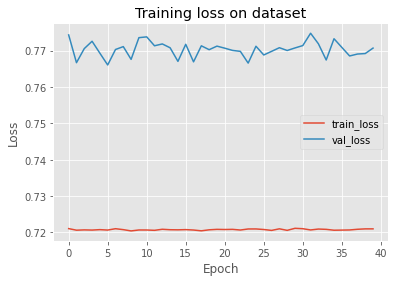

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training loss on dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower_left")
plt.savefig(cfg["base_output"])

# serialize the model to disk
torch.save(model, cfg["base_output"] + "/pyimagesearch_example.pth")

In [ ]:
def prepare_plot(original_img, original_mask, pred_mask):
  # initialize our figure
  figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))

  # plot original image, its mask, and the predicted mask
  ax[0].imshow(original_img)
  ax[1].imshow(original_mask)
  ax[2].imshow(pred_mask)

  # set the titles of the subplots
  ax[0].set_title("image")
  ax[1].set_title("original mask")
  ax[2].set_title("predicted mask")

  # set the layout of the figure and display it
  figure.tight_layout()
  figure.show()



In [ ]:
def make_predictions(model, image_path):
  # set the model evaluation mode
  model.eval()

  # turn off gradient tracking
  with torch.no_grad():
    # load the image from disk, swap its color channels, cast it to float data
    # type and scale its pixel values
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255.0

    # resize the image and make a copy of it for visualization
    image = cv2.resize(image, (224, 224))
    orig = image.copy()

    # find the filename and generate the path to ground truth mask
    filename = image_path.split(os.path.sep)[-1]
    ground_truth_path = os.path.join(cfg["test_mask_dataset"], filename)

    # load the ground truth segmentation mask in grayscale mode and resize it
    gt_mask = cv2.imread(ground_truth_path, 0)
    gt_mask = cv2.resize(gt_mask, (cfg["input_image_height"], cfg["input_image_width"]))

    # make the channel axis to be the leading one, add a batch dimension, create a pytorch
    # tensor, and flash it to the current device
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image).to(cfg['device'])

    # make the prediction, pass the results through the sigmoid function
    # and convert the result to a numpy array
    pred_mask = model(image).squeeze()
    pred_mask = torch.sigmoid(pred_mask)
    pred_mask = pred_mask.cpu().numpy()

    # filter out the weak predictions and convert them to integers
    pred_mask = (pred_mask > cfg['threshold'])*255
    pred_mask = pred_mask.astype(np.uint8)

    # prepare a plot for visualization
    prepare_plot(orig, gt_mask, pred_mask)

In [ ]:
test_img_filenames = os.listdir(cfg["test_image_dataset"])
img_paths = [cfg["test_image_dataset"] + "/" + file for file in test_img_filenames]


[INFO] loading up test image paths...
[INFO] load up model...


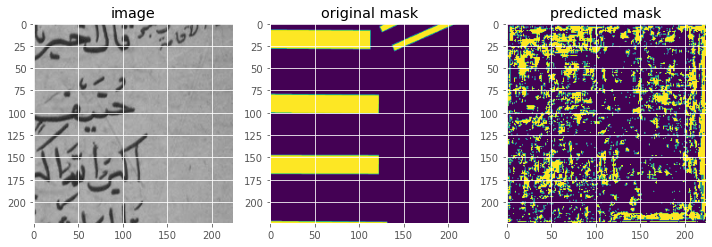

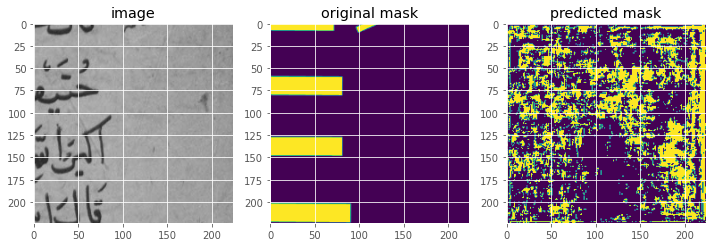

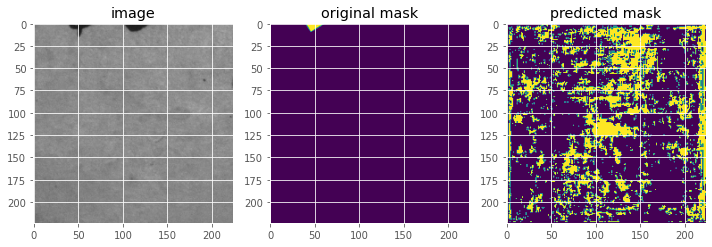

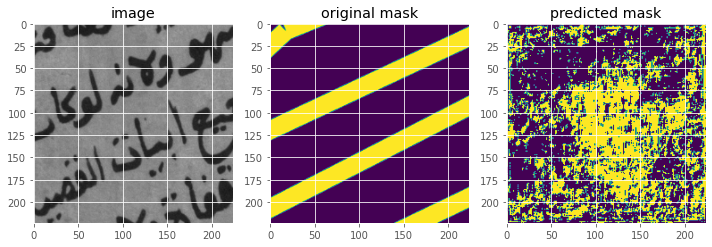

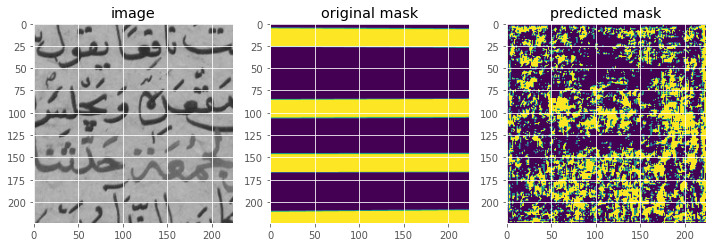

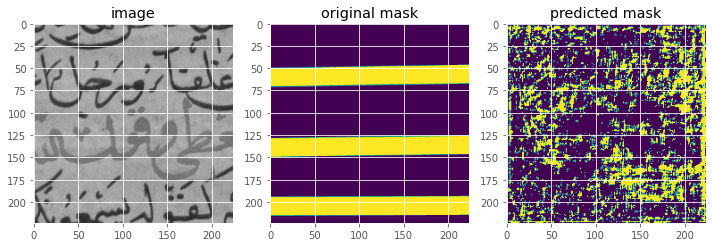

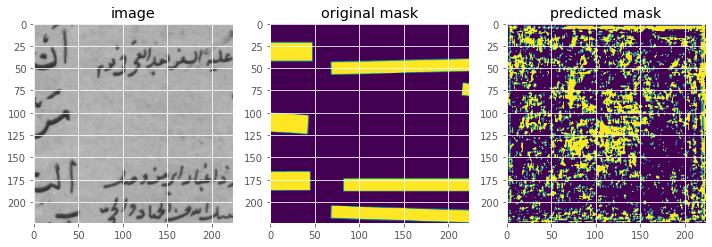

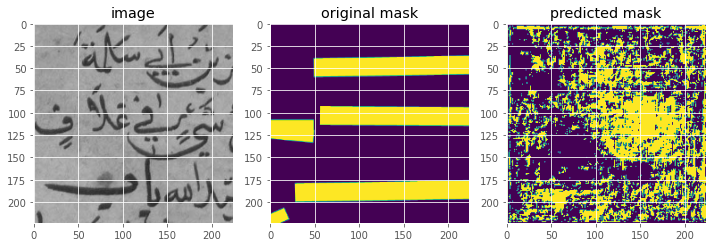

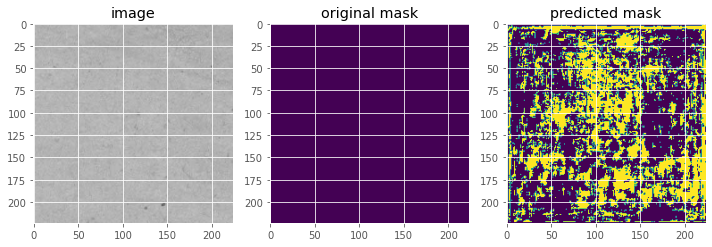

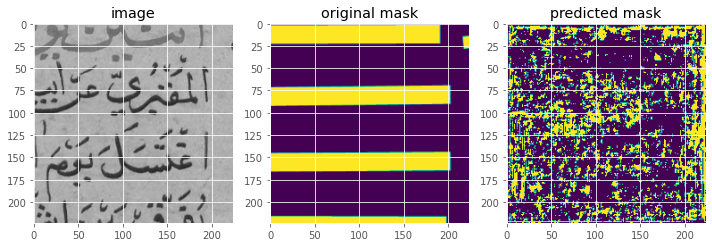

In [ ]:

# load the image paths in out testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
img_paths = np.random.choice(img_paths, size=10)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
model = torch.load(cfg["base_output"] + "/pyimagesearch_example.pth").to(cfg["device"])

# iterate over the randomly selected test image paths
for path in img_paths:
  # make predictions and visualize the results
  make_predictions(model, path)
